In [5]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install geopandas


   ---------------------------------------- 0.0/323.6 kB ? eta -:--:--
   ----------- ---------------------------- 92.2/323.6 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------  317.4/323.6 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------  317.4/323.6 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------  317.4/323.6 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 323.6/323.6 kB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
    --------------------------------------- 0.4/15.9 MB 8.2 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/15.9 MB 13.3 MB/s eta 0:00:02
   ---- ----------------------------------- 1.7/15.9 MB 13.8 MB/s eta 0:00:02
   ------ --------------------------------- 2.5/15.9 MB 14.3 MB/s eta 0:00:01
   -------- ------------------------------- 3.2/15.9 MB 14.7 MB/s eta 0:00:01
   --------- ------------------------------ 3.9/15.9 MB 14.6 MB/s eta 

In [8]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [1]:
### 1. import des librairies ###
import rasterio
from rasterio.mask import mask
from rasterio.transform import from_origin
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyproj import Proj, transform
from scipy.interpolate import interp1d

In [7]:
### 2. Pré-traitements ###
# Chemin vers les bandes individuelles de l'image satellite
band4_path = "D:/ZOSTERES/DONNEES/OLERON/S2A_MSIL2A_20180713T105621_N0208_R094_T30TXR_20180713T140348.SAFE/S2A_MSIL2A_20180713T105621_N0208_R094_T30TXR_20180713T140348.SAFE/GRANULE/L2A_T30TXR_A015964_20180713T110521/IMG_DATA/R10m/T30TXR_20180713T105621_B04_10m.jp2"
band8_path = "D:/ZOSTERES/DONNEES/OLERON/S2A_MSIL2A_20180713T105621_N0208_R094_T30TXR_20180713T140348.SAFE/S2A_MSIL2A_20180713T105621_N0208_R094_T30TXR_20180713T140348.SAFE/GRANULE/L2A_T30TXR_A015964_20180713T110521/IMG_DATA/R10m/T30TXR_20180713T105621_B08_10m.jp2"

In [12]:
# Chemin vers le fichier GeoJSON contenant les zones d'intérêts
geojson_path = "D:/ZOSTERES/DONNEES/ZONES_ZOSTERES/REPRO_ZOSTR.geojson"

# Charger le fichier GeoJSON en tant que GeoDataFrame
geojson = gpd.read_file(geojson_path)

In [13]:
# Fonction pour lire et découper les bandes selon les géométries du GeoJSON
def read_and_crop_band(band_path, geojson):
    # Ouvrir le fichier raster
    with rasterio.open(band_path) as src:
        # Appliquer le masque pour découper l'image selon les géométries du GeoJSON
        out_image, out_transform = mask(src, geojson.geometry, crop=True)
        # Copier les métadonnées de l'image raster d'origine
        out_meta = src.meta.copy()
        # Mettre à jour les métadonnées avec les nouvelles dimensions et transformations
        out_meta.update({"driver": "JP2",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
    return out_image[0], out_meta

In [14]:
# Lecture et découpage des bandes 4 (rouge) et 8 (infrarouge)
band4, meta4 = read_and_crop_band(band4_path, geojson)
band8, meta8 = read_and_crop_band(band8_path, geojson)

C:\Users\leamo\AppData\Local\Temp\ipykernel_16788\2054645328.py:4: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


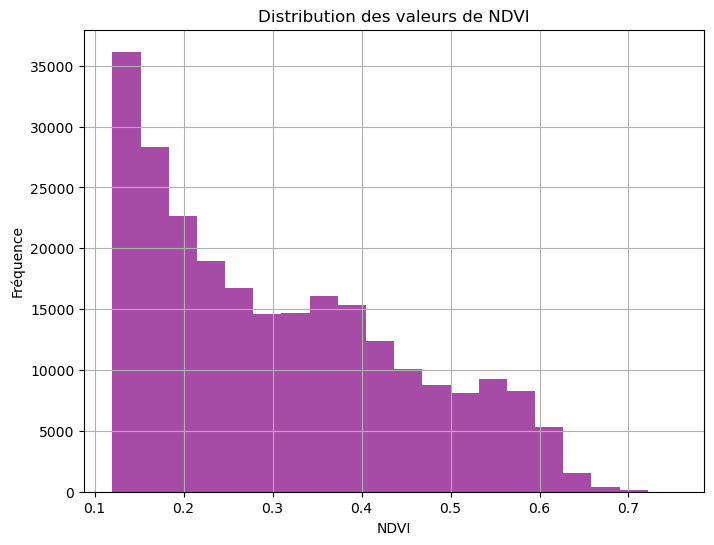

In [15]:
### 3. Calcul du NDVI ###
# Fonction pour calculer le NDVI à partir des bandes rouge et infrarouge
def calculate_ndvi(nir, red):
    ndvi = (nir - red) / (nir + red)
    return ndvi
    
# Calcul du NDVI
ndvi = calculate_ndvi(band8, band4)

# Filtrage des valeurs de NDVI entre 0.12 et 0.8
ndvi_filtered = np.where((ndvi >= 0.12) & (ndvi <= 0.8), ndvi, np.nan)

# Supprimer les valeurs NaN pour l'histogramme
ndvi_filtered_flat = ndvi_filtered[~np.isnan(ndvi_filtered)]

# Créer et afficher l'histogramme de la distribution des valeurs de NDVI
plt.figure(figsize=(8, 6))
plt.hist(ndvi_filtered_flat, bins=20, color='purple', alpha=0.7)
plt.title('Distribution des valeurs de NDVI')
plt.xlabel('NDVI')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [16]:
### 4. Traitement des données CSV ###
# Chemin vers le fichier CSV existant contenant les données terrain
csv_path = "D:/ZOSTERES/DONNEES/REF/données vérif terrain/ZOSTR_2018_OLERON.csv"

# Lire le fichier CSV existant avec un encodage spécifié
df = pd.read_csv(csv_path, encoding='ISO-8859-1', sep=';')

# Fonction pour convertir les valeurs de la colonne FRAG_corr
def convert_frag_value(value):
    if value == 1:
        return 1
    elif value == 2:
        return 0.9
    elif value == 3:
        return 0.6
    elif value == 4:
        return 0.25
    elif value == 5:
        return 0.1
    else:
        return value

# Appliquer la fonction de conversion à la colonne FRAG_corr
df['FRAG_corr'] = df['FRAG_corr'].apply(convert_frag_value)

# Afficher les premières lignes du DataFrame pour vérifier le résultat
print(df.head())

   NUM_GPS ID_STATION  Num_Grille    X_WGS84    Y_WGS84  RECOUVREMENT  \
0        1   OLER0002           2  -1,193049  45,862869            70   
1        2   OLER0005           5   -1,19182  45,863808            25   
2        3   OLER0013          13  -1,190649  45,865646            15   
3        4   OLER0016          16  -1,194567  45,866423            90   
4        5   OLER0033          33   -1,18825  45,868423             0   

   RECOUV_corr  FRAGMENTAT  FRAG_corr       NDVI REMARQUES  
0           70           4       0.25   0,070032       NaN  
1           10           4       0.25  0,1438875       NaN  
2            5           4       0.25    0,24209       NaN  
3           90           2       0.90    0,48716       NaN  
4            0           5       0.10   0,146168       NaN  


In [17]:
# Sauvegarder le nouveau fichier CSV avec les valeurs converties
new_csv_path = "D:/ZOSTERES/DONNEES/ZOSTR_2018_NDVI.csv"
df.to_csv(new_csv_path, index=False, sep=';')

C:\Users\leamo\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\leamo\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\leamo\AppData\Local\Temp\ipykernel_16788\2747842265.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df['X_UTM30N'

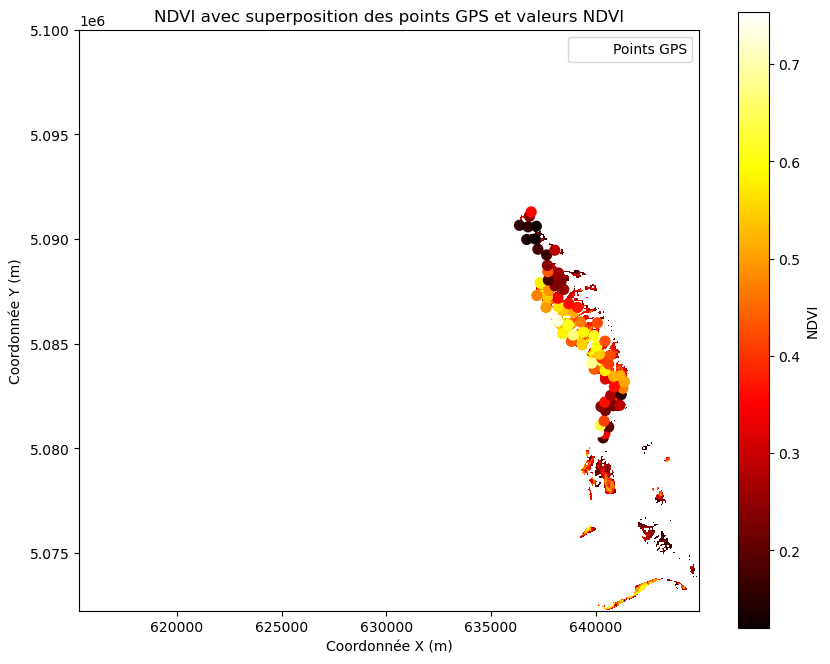

In [18]:
# Remplacer les virgules par des points dans les colonnes de coordonnées GPS
df['X_WGS84'] = df['X_WGS84'].str.replace(',', '.')
df['Y_WGS84'] = df['Y_WGS84'].str.replace(',', '.')

# Convertir les coordonnées GPS WGS84(EPSG:4326) en UTM zone 30N (EPSG:32630)
df['X_UTM30N'], df['Y_UTM30N'] = transform(Proj(init='epsg:4326'), Proj(init='epsg:32630'), df['X_WGS84'].astype(float).values, df['Y_WGS84'].astype(float).values)

# Créer une nouvelle colonne pour les valeurs de NDVI correspondant à chaque point GPS
df['NDVI_value'] = np.nan

# Remplir la nouvelle colonne avec les valeurs de NDVI correspondant aux points GPS
for index, row in df.iterrows():
    x = row['X_UTM30N']
    y = row['Y_UTM30N']
    # Convertir les coordonnées UTM en indices de pixel dans l'image NDVI
    col, row = ~meta8['transform'] * (x, y)
    col, row = int(col), int(row)
    # Vérifier si les indices sont valides
    if 0 <= row < ndvi_filtered.shape[0] and 0 <= col < ndvi_filtered.shape[1]:
        # Récupérer la valeur de NDVI correspondant aux indices
        ndvi_value = ndvi_filtered[row, col]
        # Remplir la colonne NDVI_value avec la valeur de NDVI
        df.at[index, 'NDVI_value'] = ndvi_value

# Affichage du NDVI avec les points GPS superposés
plt.figure(figsize=(10, 8))
plt.imshow(ndvi_filtered, cmap='hot', extent=[meta8['transform'][2], meta8['transform'][2] + ndvi_filtered.shape[1]*meta8['transform'][0],
                                                  meta8['transform'][5] + ndvi_filtered.shape[0]*meta8['transform'][4], meta8['transform'][5]])
plt.colorbar(label='NDVI')
plt.scatter(df['X_UTM30N'], df['Y_UTM30N'], c=df['NDVI_value'], cmap='hot', s=50, marker='o', label='Points GPS')
plt.title('NDVI avec superposition des points GPS et valeurs NDVI')
plt.xlabel('Coordonnée X (m)')
plt.ylabel('Coordonnée Y (m)')
plt.legend()
plt.show()

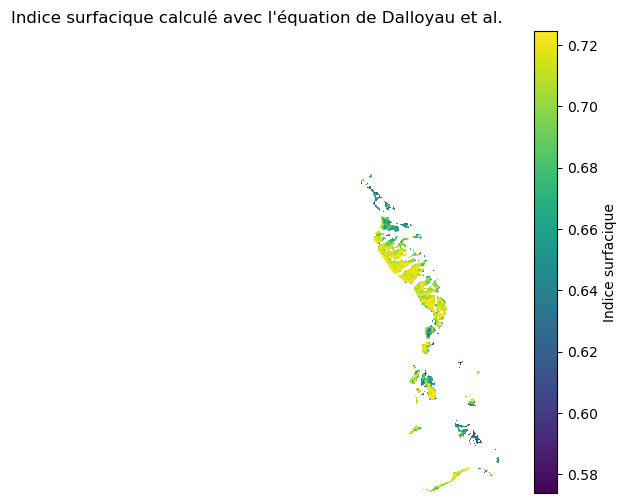

In [19]:
### 5. Calcul de l'indice surfacique  ###
# Calcul de l'équation de Dalloyau et al. 2023 pour l'indice surfacique
indice_surf = 1.0 / (1.0 + np.exp(-1.0 * (-5.1802 * ndvi_filtered * ndvi_filtered + 4.9689 * ndvi_filtered - 0.2242)))

# Affichage de l'indice surfacique
plt.figure(figsize=(8, 6))
plt.imshow(indice_surf, cmap='viridis')  # Choisissez la colormap appropriée
plt.colorbar(label='Indice surfacique')
plt.title('Indice surfacique calculé avec l\'équation de Dalloyau et al.')
plt.axis('off')
plt.show()

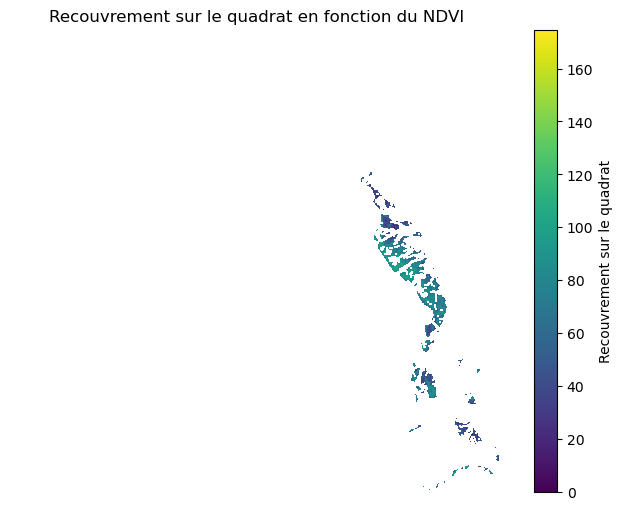

In [20]:
### 6. Interpolation et calcul des images de recouvrement et de fragmentation ###
# Créer les fonctions d'interpolation pour le recouvrement et la fragmentation
interp_recouvrement = interp1d(df['NDVI_value'], df['RECOUV_corr'], bounds_error=False, fill_value="extrapolate")
interp_fragmentation = interp1d(df['NDVI_value'], df['FRAG_corr'], bounds_error=False, fill_value="extrapolate")

# Appliquer l'interpolation aux pixels de l'image NDVI pour obtenir les images de recouvrement et de fragmentation
recouvrement_quadrat = interp_recouvrement(ndvi_filtered)
fragmentation_herbier = interp_fragmentation(ndvi_filtered)

# Affichage du recouvrement sur le quadrat
plt.figure(figsize=(8, 6))
plt.imshow(recouvrement_quadrat, cmap='viridis')  # Choisissez la colormap appropriée
plt.colorbar(label='Recouvrement sur le quadrat')
plt.title('Recouvrement sur le quadrat en fonction du NDVI')
plt.axis('off')
plt.show()

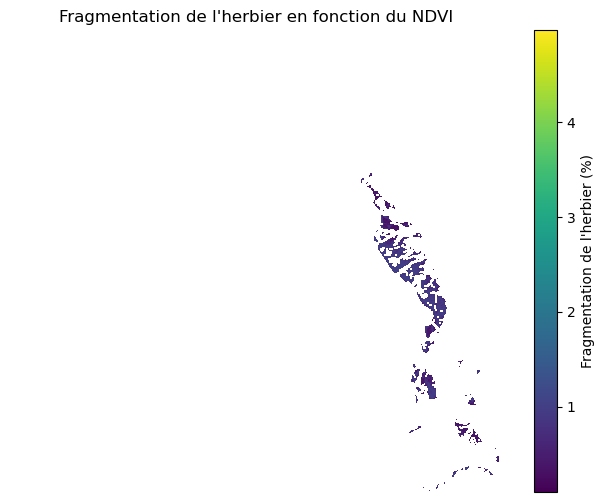

In [21]:
# Affichage de la fragmentation de l'herbier
plt.figure(figsize=(8, 6))
plt.imshow(fragmentation_herbier, cmap='viridis')  # Choisissez la colormap appropriée
plt.colorbar(label='Fragmentation de l\'herbier (%)')
plt.title('Fragmentation de l\'herbier en fonction du NDVI')
plt.axis('off')
plt.show()

C:\Users\leamo\AppData\Local\Temp\ipykernel_16788\3744831051.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(fragmentation_flat, bins=20, palette='Blues', alpha=0.5)
C:\Users\leamo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


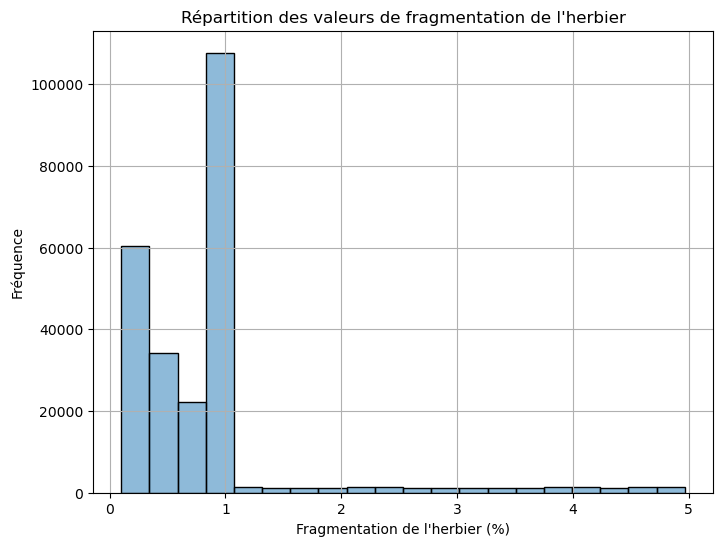

In [25]:
# Flattening des valeurs de fragmentation de l'herbier pour l'histogramme
fragmentation_flat = fragmentation_herbier.flatten()

# Création de l'histogramme avec une palette de couleurs
plt.figure(figsize=(8, 6))
sns.histplot(fragmentation_flat, bins=20, palette='Blues', alpha=0.5)
plt.title('Répartition des valeurs de fragmentation de l\'herbier')
plt.xlabel('Fragmentation de l\'herbier (%)')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

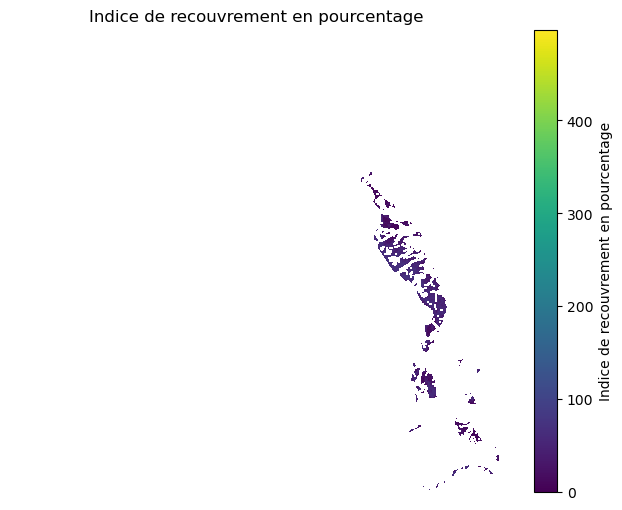

In [26]:
### 7. Calcul du pourcentage de recouvrement théorique ###
# Calcul du pourcentage de rcouvrement théorique
pourcentage_recouvrement_theorique = recouvrement_quadrat * fragmentation_herbier

# Calcul de l'indice de recouvrement en pourcentage
indice_surf = 1.0 / (1.0 + np.exp(-1.0 * (-5.1802 * ndvi_filtered * ndvi_filtered + 4.9689 * ndvi_filtered - 0.2242)))
indice_recouvrement_pourcentage = indice_surf * pourcentage_recouvrement_theorique

# Affichage de l'indice de recouvrement en pourcentage
plt.figure(figsize=(8, 6))
plt.imshow(indice_recouvrement_pourcentage, cmap='viridis')  # Choisissez la colormap appropriée
plt.colorbar(label='Indice de recouvrement en pourcentage')
plt.title('Indice de recouvrement en pourcentage')
plt.axis('off')
plt.show()